In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import imageio
import geopandas as gpd
from IPython.display import Image, display
import tensorflow as tf
from tensorflow.keras import layers, callbacks, backend, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
from keras.preprocessing import image

In [2]:
df=pd.read_csv("F:\\CNOOC_testing\\Methane_dataset\\METHANE_PROJECT\\smallsize224_all.csv")

In [3]:
df.shape

(86599, 10)

In [4]:
df.Type.value_counts()

Negative                                        34869
CAFOs                                           25073
WWTreatment                                     14441
Landfills                                        4053
RefineriesAndTerminals                           3961
ProcessingPlants                                 1975
Mines                                            1816
WWTreatment-RefineriesAndTerminals                114
WWTreatment-Landfills                              76
Mines-Landfills                                    58
RefineriesAndTerminals-ProcessingPlants            47
RefineriesAndTerminals-Landfills                   31
RefineriesAndTerminals-WWTreatment                 17
CAFOs-WWTreatment                                  16
WWTreatment-ProcessingPlants                       13
WWTreatment-Mines                                   8
CAFOs-Landfills                                     7
ProcessingPlants-Landfills                          6
WWTreatment-RefineriesAndTer

In [5]:
df=df.dropna()

In [6]:
df.head(2)

,Unnamed: 0,Latitude,Longitude,Type,Source,Image_Folder,geometry,dataset,Image_Folder_long_lat,img_dir
0,0,43.948271,-93.649496,CAFOs,MinnesotaPollutionControlAgency,train_images/43.94827109_-93.6494963,POLYGON ((-93.64626236497716 43.95060750304138...,train,43.94827109_-93.6494963,F:\\CNOOC_testing\\Methane_dataset\\METHANE_PR...
1,1,43.004434,-78.208900,Negative,Aeroplanes,train_images/43.00443446102501_-78.20890003579709,POLYGON ((-78.20566610077425 43.00680791855935...,train,43.00443446102501_-78.20890003579709,F:\\CNOOC_testing\\Methane_dataset\\METHANE_PR...


In [7]:
df.Type = df.Type.astype(str)

In [8]:
df_train=df.loc[df['dataset'] == "train"]

In [9]:
df_test=df.loc[df['dataset'] == "test"]

In [10]:
df_train.shape

(85066, 10)

In [11]:
df_train=df_train[(df_train.Type == 'Negative') | (df_train.Type == 'CAFOs') | (df_train.Type == 'WWTreatment')
           | (df_train.Type == 'Landfills') | (df_train.Type == 'RefineriesAndTerminals')
           | (df_train.Type == 'ProcessingPlants') | (df_train.Type == 'Mines')]

In [12]:
df_test=df_test[(df_test.Type == 'Negative') | (df_test.Type == 'CAFOs') | (df_test.Type == 'WWTreatment')
           | (df_test.Type == 'Landfills') | (df_test.Type == 'RefineriesAndTerminals')
           | (df_test.Type == 'ProcessingPlants') | (df_test.Type == 'Mines')]

In [13]:
df_train.shape

(84693, 10)

In [14]:
df_test.shape

(990, 10)

In [15]:
df_train.Type.value_counts()

Negative                  34195
CAFOs                     24934
WWTreatment               14296
Landfills                  3915
RefineriesAndTerminals     3817
ProcessingPlants           1830
Mines                      1706
Name: Type, dtype: int64

In [16]:
#def sampling_k_elements(group, k=1600):
#    if len(group) < k:
#        return group
#    return group.sample(k)
#balanced = df_train.groupby('Type').apply(sampling_k_elements).reset_index(drop=True)

In [37]:
SEED = 42
CATEGORIES = 6
TRAIN_BATCH_SIZE = 32
VAL_SPLIT = 0.2

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNEL = 3

In [52]:
class MyDataFrameIterator(image.DataFrameIterator):
    def __init__(self, *args, **kwargs):
        return super().__init__(*args, **kwargs)

    def __getitem__(self, idx):
        X_, y_ = super().__getitem__(idx)
        y_ = np.delete(y_, self.class_indices['Negative'], axis=1)
        return X_, y_
    
    def next(self):
        X_, y_ = super().next()
        y_ = np.delete(y_, self.class_indices['Negative'], axis=1)
        return X_, y_
    
class MyImageDataGenerator(image.ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        return super().__init__(self, *args, **kwargs)
    
    def flow_from_dataframe(self, df, directory, *args, **kwargs):
        return MyDataFrameIterator(df, directory, *args, **kwargs)

In [53]:
datagen=MyImageDataGenerator(rescale=1./255,
                                 #validation_split = VAL_SPLIT,
                                 #rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 #horizontal_flip=True
                                )

In [87]:
train_generator=datagen.flow_from_dataframe(
    df_train,
    "",
    x_col="img_dir",
    y_col="Type",
    color_mode='rgb',
    seed = 42,
    class_mode="categorical",
    validate_filenames=False,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=TRAIN_BATCH_SIZE)

Found 67755 non-validated image filenames belonging to 7 classes.


In [55]:
val_generator = datagen.flow_from_dataframe(
    df_train,
    "",
    x_col="img_dir",
    y_col="Type",
    color_mode='rgb',
    seed = 42,
    class_mode="categorical",
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    validate_filenames=False,
    batch_size=TRAIN_BATCH_SIZE)

Found 67755 non-validated image filenames belonging to 7 classes.


In [56]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [57]:
def build_model():
    inputs = layers.Input(shape=(224, 224, 3))
    
    # the densenet layer
    x = tf.keras.applications.DenseNet121(include_top=False,
                      weights='imagenet',
                      pooling='max'
                      )(inputs)
    
    #x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    out = layers.Dense(CATEGORIES, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=out)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        'accuracy'
    ])
    return model

In [58]:
backend.clear_session()
model = build_model()
model.layers[1].trainable=False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 16)                16400     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102       
Total params: 7,054,006
Trainable params: 16,502
Non-trainable params: 7,037,504
_________________________________________________________________


In [48]:
cb = [callbacks.EarlyStopping(patience=5),
      callbacks.ReduceLROnPlateau(patience=3),
      callbacks.ModelCheckpoint('carla_v0.hdf5',
                                monitor='loss',
                                verbose=1,
                                save_best_only=True)]
epochs = 3
# fits the model on batches with real-time data augmentation:

history =model.fit_generator(generator=train_generator,
                          steps_per_epoch=STEP_SIZE_TRAIN,
                          validation_data=val_generator,
                          validation_steps=STEP_SIZE_VALID,
                          epochs=epochs,
                          callbacks = cb)

Epoch 1/3
2117/2117 [==============================] - 995s 470ms/step - loss: 0.1138 - auc: 0.9659 - pr_auc: 0.8615 - precision: 0.8715 - recall: 0.7025 - accuracy: 0.5407 - val_loss: 0.1360 - val_auc: 0.9575 - val_pr_auc: 0.8248 - val_precision: 0.8443 - val_recall: 0.6379 - val_accuracy: 0.4930

Epoch 00001: loss improved from inf to 0.11381, saving model to carla_v0.hdf5
Epoch 2/3
2117/2117 [==============================] - 926s 437ms/step - loss: 0.1023 - auc: 0.9721 - pr_auc: 0.8842 - precision: 0.8822 - recall: 0.7396 - accuracy: 0.5485 - val_loss: 0.1339 - val_auc: 0.9520 - val_pr_auc: 0.8391 - val_precision: 0.8885 - val_recall: 0.6542 - val_accuracy: 0.5496

Epoch 00002: loss improved from 0.11381 to 0.10230, saving model to carla_v0.hdf5
Epoch 3/3
2117/2117 [==============================] - 932s 440ms/step - loss: 0.0980 - auc: 0.9743 - pr_auc: 0.8925 - precision: 0.8874 - recall: 0.7525 - accuracy: 0.5520 - val_loss: 0.1142 - val_auc: 0.9645 - val_pr_auc: 0.8686 - val_pre

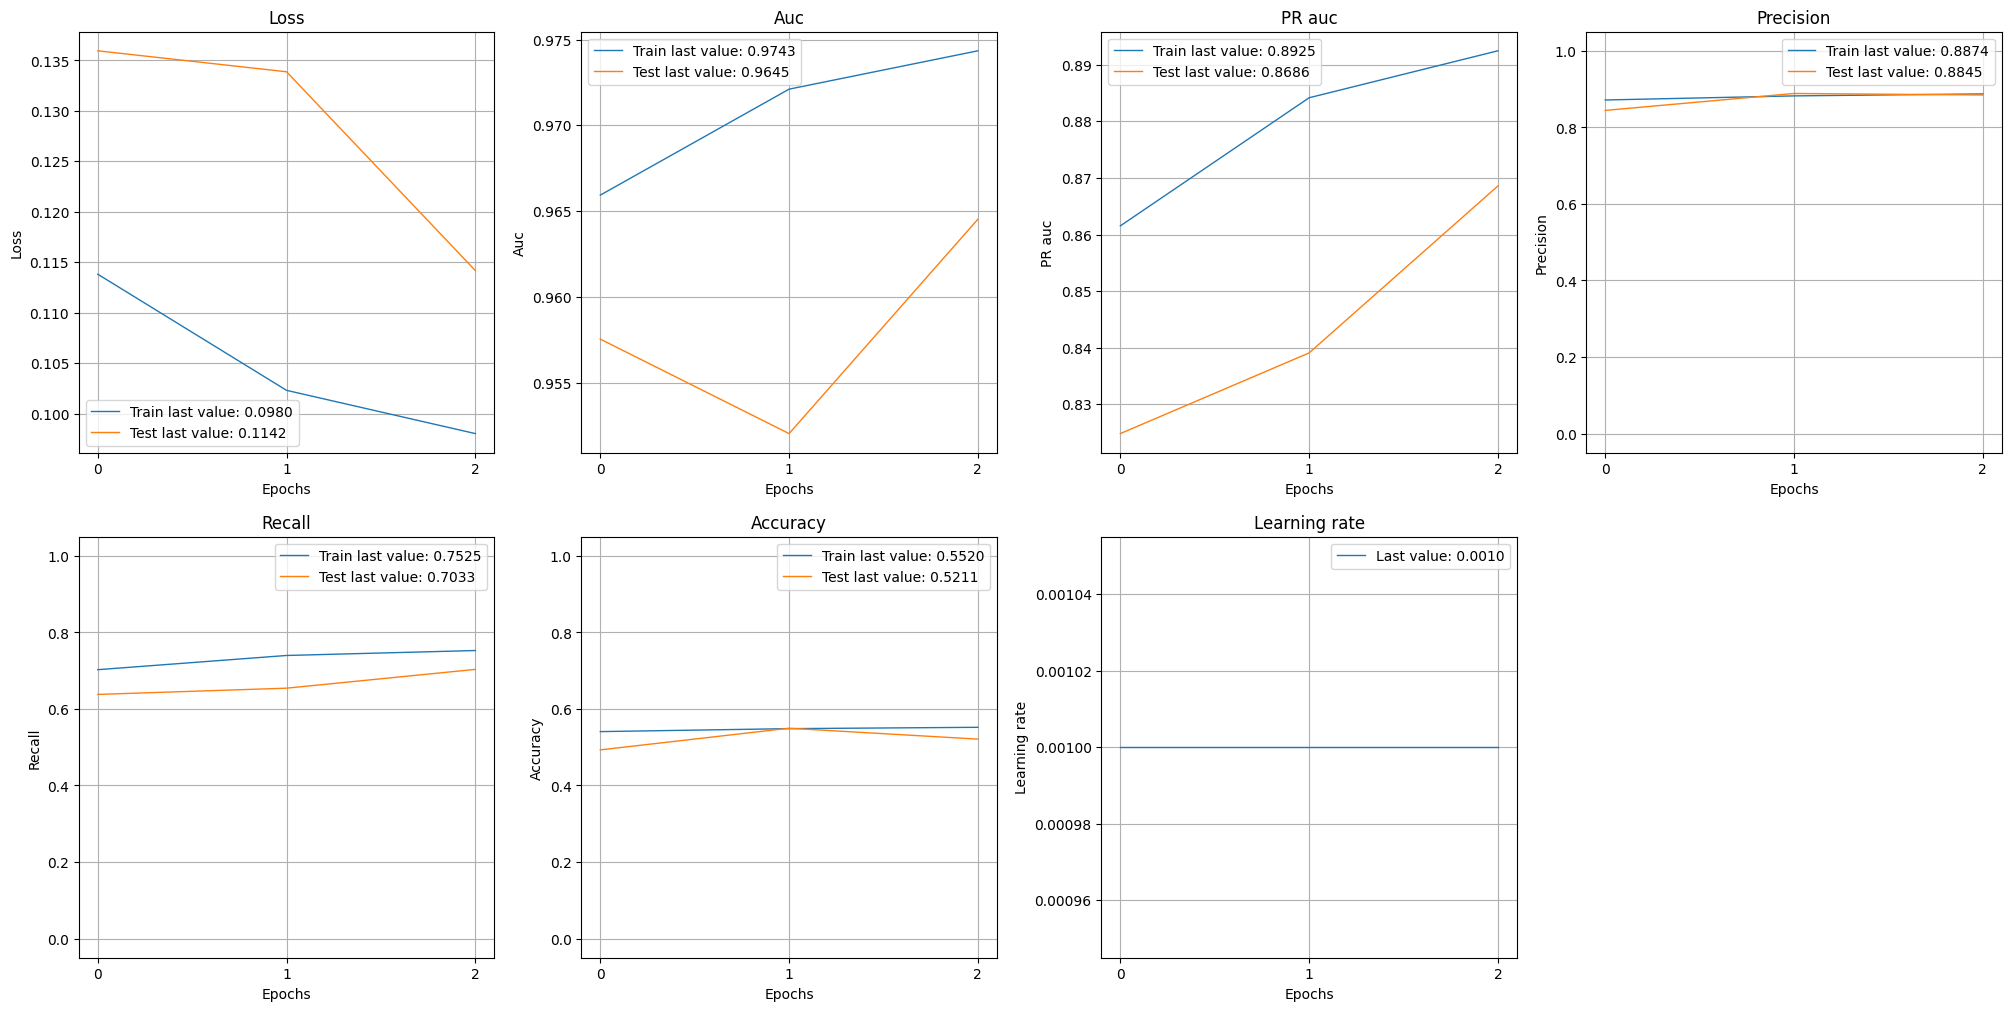

In [49]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [157]:
TEST_BATCH_SIZE = 16

test_gen = datagen.flow_from_dataframe(
    df_test,
    "",
    x_col="img_dir",
    y_col="Type",
    color_mode='rgb',
    seed = 42,
    class_mode="categorical",
    validate_filenames=False,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=TEST_BATCH_SIZE)

Found 990 non-validated image filenames belonging to 7 classes.


In [ ]:
cat_names = list(test_gen.class_indices.keys())
cat_names.remove('Negative')
cat_names

In [162]:
X_test, y_test = test_gen.next()
y_pred_proba = model.predict(X_test)

# SAVING THE ARRAY, PLEASE UPDATE THE NAME SO IT DOES nOT OVERWRITE

# :)

And keep track of what you sensitized on so we can compare metrics :)

In [ ]:
np.save('y_pred_proba_1.npy', y_pred_proba)
np.save('y_test_1.npy', y_test)

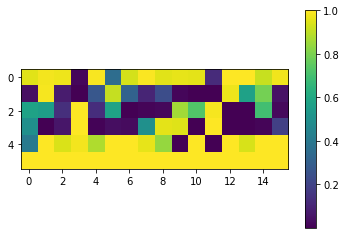

In [168]:
plt.imshow(y_pred_proba.T)
plt.colorbar()
plt.show()

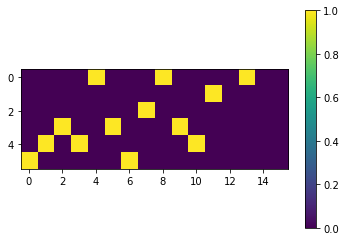

In [167]:
plt.imshow(y_test.T)
plt.colorbar()
plt.show()

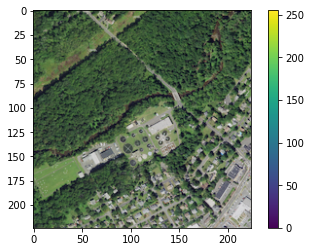

In [169]:
# Plot a sample image from the test set
abc = X_test[0,:,:,:].reshape(224, 224, 3).astype(np.uint8)
plt.imshow(abc)
plt.colorbar()
plt.show()

In [170]:
# Instantiate metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()
pr_auc = tf.keras.metrics.AUC(name='pr_auc', curve='PR')
accuracy = tf.keras.metrics.Accuracy()

In [143]:
# Binarize predictions
y_pred = (y_pred_proba> 0.5).astype(int)

In [181]:
prec_cat = {}
recall_cat = {}
auc_cat = {}
pr_auc_cat = {}
accuracy_cat = {}
overall_cat = {}

for idx, name in enumerate(cat_names):
    prec_cat[name] = precision(y_test[:][idx], y_pred[:][idx]).numpy()
    recall_cat[name] = recall(y_test[:][idx], y_pred[:][idx]).numpy()
    auc_cat[name] = auc(y_test[:][idx], y_pred[:][idx]).numpy()
    pr_auc_cat[name] = pr_auc(y_test[:][idx], y_pred[:][idx]).numpy()
    accuracy_cat[name] = accuracy(y_test[:][idx], y_pred[:][idx]).numpy()
    overall_cat[name] = np.mean([prec_cat[name], recall_cat[name], auc_cat[name],
                                pr_auc_cat[name], accuracy_cat[name]])


In [182]:
metrics_df = pd.DataFrame({
    'Category': cat_names,
    'Precision': list(prec_cat.values()),
    'Recall': list(recall_cat.values()),
    'AUC': list(auc_cat.values()),
    'PR AUC': list(pr_auc_cat.values()),
    'Accuracy': list(accuracy_cat.values()),
    'Overall': list(overall_cat.values())
})

print(metrics_df)

                 Category  Precision    Recall       AUC    PR AUC  Accuracy  \
0                   CAFOs   0.200000  0.714286  0.636735  0.255439       0.0   
1               Landfills   0.200000  0.727273  0.648347  0.264052       0.0   
2                   Mines   0.192771  0.695652  0.626465  0.253409       0.0   
3        ProcessingPlants   0.195402  0.708333  0.626736  0.243232       0.0   
4  RefineriesAndTerminals   0.200000  0.720000  0.633600  0.244101       0.0   
5             WWTreatment   0.191489  0.692308  0.609468  0.231550       0.0   

    Overall  
0  0.361292  
1  0.367934  
2  0.353659  
3  0.354741  
4  0.359540  
5  0.344963  
